In [1]:
#import libraries
from datetime import datetime, timedelta
from shapely.geometry import Point, Polygon
import pandas as pd
import csv
import numpy as np
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# import dataset
northern_gannet_df = pd.read_csv("C:/Users/Dovekie/Documents/PelagicBirdProgram/datasets/noga/noga_obsv_200601-202312_masscoast_50.csv", sep='\t', index_col=["Unnamed: 0"])
weather_df = pd.read_csv("C:/Users/Dovekie/Documents/PelagicBirdProgram/datasets/noga/noga_weather_200601-202312_masscoast_50_000-012_3.csv", sep='\t', index_col=["Unnamed: 0"])

In [3]:
northern_gannet_df.head(50)

,OBSERVATION COUNT,LATITUDE,LONGITUDE,year,month,day,days_cos,days_sin
0,0,41.67,-70.08,2006,1,1,0.999853,0.017166
1,1,42.80,-70.81,2006,1,2,0.999411,0.034328
2,2,41.77,-70.50,2006,1,2,0.999411,0.034328
3,0,41.57,-70.51,2006,1,2,0.999411,0.034328
4,3,41.77,-70.49,2006,1,2,0.999411,0.034328
5,71,42.69,-70.62,2006,1,3,0.998674,0.051479
6,250,41.82,-70.00,2006,1,4,0.997643,0.068615
7,2,42.58,-70.66,2006,1,6,0.994700,0.102821
8,0,41.76,-70.49,2006,1,7,0.992788,0.119881
9,0,42.80,-70.81,2006,1,12,0.978856,0.204552


### Data Preprocessing

In [4]:
# take the log of each count to help the model understand the correlation better (the data is exponential)
observation_column=northern_gannet_df['OBSERVATION COUNT'].tolist()
# since log is not defined for x=0, we can convert the counts to log(x+1)
northern_gannet_df['OBSERVATION COUNT']=pd.Series([np.log(x+1) for x in observation_column])

In [5]:
noga_log=northern_gannet_df

In [10]:
noga_log=noga_log[noga_log['OBSERVATION COUNT']!=0]

In [ ]:
#noga_log=noga_log[~noga_log['month'].isin([1,2,3,4,5,6,7,8,12])]
#noga_log.head(10)

In [6]:
noga_log.shape

(31753, 8)

In [7]:
# FASTER CODE: for polygonal region with few boundary points
noga_log=noga_log[noga_log['LONGITUDE']>=-70.64112479594434]
noga_log=noga_log[noga_log['LATITUDE']>=42.68138642588193]
noga_log=noga_log[noga_log['LONGITUDE']<=-70.61618444441049]
noga_log=noga_log[noga_log['LATITUDE']<=42.69585507137888]

In [13]:
# SLOWER CODE: (for more boundary points) coordinates for a square region containing Halibut and Andrews Point, Rockport
rockport_coords = []
coord_list=[-70.64112479594434,42.68138642588193,-70.61618444441049,42.68113627754815,-70.61615355585212,42.69585507137888,-70.64109523776845,42.69590535503056,-70.64112479594434,42.68138642588193]
for x in range(len(coord_list)):
    if x%2==0:
        lng=coord_list[x]
    else:
        lat=coord_list[x]
        coord = (lng,lat)
        rockport_coords += [coord]
print(rockport_coords)

[(-70.64112479594434, 42.68138642588193), (-70.6161844444105, 42.68113627754815), (-70.61615355585212, 42.69585507137888), (-70.64109523776845, 42.69590535503056), (-70.64112479594434, 42.68138642588193)]


In [14]:
# SLOWER CODE: (for more boundary points) only keep observations from Halibut and Andrews Point area
the_polygon = Polygon(rockport_coords)
for index, row in noga_log.iterrows():
    the_point = Point(row['LONGITUDE'], row['LATITUDE'])
    within_polygon = the_point.within(the_polygon)
    if within_polygon==False:
        noga_log=noga_log.drop(index)

In [8]:
# reset the index of the dataframe
indices=noga_log.index
noga_log=noga_log.reset_index(drop=True)
# only keep indices that are also in noga_largest_count
weather=weather_df.loc[indices].reset_index(drop=True)
# create new series with just the observation count
northern_gannet=noga_log['OBSERVATION COUNT']
weather_complete=pd.concat([weather, noga_log[['LATITUDE', 'LONGITUDE', 'days_cos', 'days_sin']]], axis=1)

In [9]:
northern_gannet.tail(10)

2083    3.044522
2084    5.017280
2085    0.693147
2086    2.197225
2087    0.693147
2088    0.693147
2089    1.386294
2090    0.693147
2091    0.693147
2092    0.693147
Name: OBSERVATION COUNT, dtype: float64

In [10]:
weather_complete.head(10)

,temp000,temp003,temp006,temp009,temp012,prcp000,prcp003,prcp006,prcp009,prcp012,...,windx012,windy000,windy003,windy006,windy009,windy012,LATITUDE,LONGITUDE,days_cos,days_sin
0,1.7,2.2,0.6,0.6,1.7,0.0,0.0,0.0,0.0,0.3,...,5.6,0.0,0.0,0.0,7.6,10.1,42.69,-70.62,0.998674,0.051479
1,0.6,2.2,3.3,3.9,6.7,0.0,0.0,0.0,1.3,0.3,...,-26.8,8.5,16.6,23.3,21.7,20.1,42.69,-70.62,0.952635,0.304115
2,0.6,0.6,0.6,-2.2,-3.9,0.0,0.0,0.0,0.0,0.0,...,-0.0,-6.5,-10.4,-7.6,-0.0,-0.0,42.69,-70.63,0.916317,0.400454
3,-0.6,-1.1,0.6,1.1,2.2,0.0,0.0,0.0,0.0,0.0,...,-5.0,-10.4,-9.0,-10.1,-13.3,-14.9,42.69,-70.62,0.886680,0.462383
4,0.6,0.0,0.6,3.9,3.3,0.0,0.0,0.0,0.0,0.3,...,13.4,5.0,6.1,5.5,14.9,17.8,42.69,-70.62,0.861702,0.507415
5,11.0,9.0,6.0,3.3,3.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-6.7,-6.8,-3.8,-6.1,-0.0,42.69,-70.62,0.824855,0.565345
6,-5.0,-6.0,-8.0,-8.0,-8.0,0.0,0.0,0.0,0.0,0.0,...,-3.9,-9.4,-13.0,-8.5,-13.0,-11.7,42.69,-70.62,0.640593,0.767880
7,7.2,5.0,5.0,5.6,5.6,0.0,0.5,0.3,0.0,0.3,...,1.9,8.5,0.0,0.0,10.1,9.4,42.69,-70.62,-0.376728,0.926324
8,10.0,9.4,10.0,10.6,9.4,0.0,0.3,0.0,3.6,0.5,...,-7.4,11.7,16.6,16.6,22.3,13.3,42.69,-70.62,-0.666575,0.745438
9,7.2,7.2,8.0,8.9,8.3,2.0,3.8,0.3,2.3,9.4,...,14.9,-0.0,7.8,6.7,8.9,5.0,42.69,-70.62,-0.679273,0.733885


### Train and test arrays

In [11]:
weather_windxy_cos_sin_1=weather_complete[weather_complete.columns[-14:-4]]
weather_windxy_cos_sin_2=weather_complete[weather_complete.columns[-2:]]
weather_windxy_cos_sin=pd.concat([weather_windxy_cos_sin_1, weather_windxy_cos_sin_2], axis=1)
weather_windxy_cos_sin.head(10)

,windx000,windx003,windx006,windx009,windx012,windy000,windy003,windy006,windy009,windy012,days_cos,days_sin
0,-0.0,-7.6,-0.0,1.5,5.6,0.0,0.0,0.0,7.6,10.1,0.998674,0.051479
1,2.8,0.0,-13.0,-7.2,-26.8,8.5,16.6,23.3,21.7,20.1,0.952635,0.304115
2,11.7,7.8,-0.0,-0.0,-0.0,-6.5,-10.4,-7.6,-0.0,-0.0,0.916317,0.400454
3,-7.8,-6.7,-3.4,-4.4,-5.0,-10.4,-9.0,-10.1,-13.3,-14.9,0.886680,0.462383
4,14.9,18.4,16.6,5.0,13.4,5.0,6.1,5.5,14.9,17.8,0.861702,0.507415
5,-9.0,-2.3,-6.8,-4.6,-0.0,-6.7,-6.8,-3.8,-6.1,-0.0,0.824855,0.565345
6,-1.9,-2.6,-2.8,-0.0,-3.9,-9.4,-13.0,-8.5,-13.0,-11.7,0.640593,0.767880
7,4.7,0.0,0.0,5.6,1.9,8.5,0.0,0.0,10.1,9.4,-0.376728,0.926324
8,3.9,-3.3,-9.2,-4.5,-7.4,11.7,16.6,16.6,22.3,13.3,-0.666575,0.745438
9,16.6,10.4,9.0,11.8,14.9,-0.0,7.8,6.7,8.9,5.0,-0.679273,0.733885


In [12]:
weather_0609_cos_sin_1=weather_windxy_cos_sin[weather_windxy_cos_sin.columns[2:4]]
weather_0609_cos_sin_2=weather_windxy_cos_sin[weather_windxy_cos_sin.columns[7:9]]
weather_0609_cos_sin_3=weather_windxy_cos_sin[weather_windxy_cos_sin.columns[-2:]]
weather_0609_cos_sin=pd.concat([weather_0609_cos_sin_1,weather_0609_cos_sin_2, weather_0609_cos_sin_3], axis=1)
weather_0609_cos_sin.head(10)

,windx006,windx009,windy006,windy009,days_cos,days_sin
0,-0.0,1.5,0.0,7.6,0.998674,0.051479
1,-13.0,-7.2,23.3,21.7,0.952635,0.304115
2,-0.0,-0.0,-7.6,-0.0,0.916317,0.400454
3,-3.4,-4.4,-10.1,-13.3,0.886680,0.462383
4,16.6,5.0,5.5,14.9,0.861702,0.507415
5,-6.8,-4.6,-3.8,-6.1,0.824855,0.565345
6,-2.8,-0.0,-8.5,-13.0,0.640593,0.767880
7,0.0,5.6,0.0,10.1,-0.376728,0.926324
8,-9.2,-4.5,16.6,22.3,-0.666575,0.745438
9,9.0,11.8,6.7,8.9,-0.679273,0.733885


In [13]:
X=weather_0609_cos_sin.to_numpy()
y=northern_gannet.to_numpy()

In [14]:
print(y)

[4.27666612 5.32787617 0.69314718 ... 0.69314718 0.69314718 0.69314718]


In [15]:
# normalize X values using StandardScaler() formula: z=(x-u)/s
# wind_X
windx_avg=np.mean(X[:, 0:2])
windx_std=np.std(X[:, 0:2])
X[:, 0:2]-=windx_avg
X[:, 0:2]=np.divide(X[:, 0:2], windx_std)
# wind_y
windy_avg=np.mean(X[:, 2:4])
windy_std=np.std(X[:, 2:4])
X[:, 2:4]-=windy_avg
X[:, 2:4]=np.divide(X[:, 2:4], windy_std)
# latitude
#latitude_avg=np.mean(X[:, 22])
#latitude_std=np.std(X[:, 22])
#X[:, 22]-=latitude_avg
#X[:, 22]=np.divide(X[:, 22], latitude_std)
# longitude
#longitude_avg=np.mean(X[:, 23])
#longitude_std=np.std(X[:, 23])
#X[:, 23]-=longitude_avg
#X[:, 23]=np.divide(X[:, 23], longitude_std)
# normalize y values using MinMaxScaler() formula: z=(y-min)/(max-min)
counts_min=np.min(y)
counts_max=np.max(y)
y-=counts_min
y=np.divide(y, counts_max-counts_min)
print(X)

[[-1.94890795e-01 -2.95657701e-02  2.87083145e-01  1.14983225e+00
   9.98674090e-01  5.14787548e-02]
 [-1.62770768e+00 -9.88450914e-01  2.93209028e+00  2.75045889e+00
   9.52635381e-01  3.04114832e-01]
 [-1.94890795e-01 -1.94890795e-01 -5.75665963e-01  2.87083145e-01
   9.16316904e-01  4.00453906e-01]
 ...
 [-1.94890795e-01 -1.94890795e-01  2.87083145e-01  2.87083145e-01
   9.97643232e-01 -6.86147380e-02]
 [-1.94890795e-01 -1.94890795e-01  2.87083145e-01  2.87083145e-01
   9.97643232e-01 -6.86147380e-02]
 [ 2.23932601e-01  3.12105948e-01 -4.84850268e-01 -4.05386534e-01
   1.00000000e+00 -2.44929360e-16]]


In [53]:
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [54]:
y_train.shape

(1402,)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=32, weights='distance')
knn.fit(X_train, y_train)

In [ ]:
y_pred=knn.predict(X_test)
print(r2_score(y_test,y_pred))

## XGBoost model

In [18]:
#!pip install xgboost
from xgboost import XGBRegressor

In [147]:
def weighted_mse(ypred, ytrue):
    # pred-true<0 implies (pred-true)**2/16, and pred-true>0 implies (pred-true)**2
    grad = 2*(ytrue-ypred)
    hess = np.repeat(2, ytrue.shape[0])
    for i in range(ytrue.shape[0]):
        if (ytrue-ypred)[i]<=0:
            grad[i] = grad[i]/16
            hess[i] = hess[i]/16
        else:
            continue
    return grad, hess

In [50]:
print(weighted_mse(y_test,y_test))

691
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [148]:
model_xgb1=XGBRegressor(n_estimators=18, max_depth=12, learning_rate=0.09, objective = weighted_mse) #'reg:squarederror'
model_xgb1.fit(X_train, y_train)
y_pred=model_xgb1.predict(X_test)

In [115]:
r2=[]
est=[i for i in range (1,51)]
for i in range (1, 51):
    model_xgb1=XGBRegressor(n_estimators=18, max_depth=i, learning_rate=0.09, objective=weighted_mse)
    model_xgb1.fit(X_train, y_train)
    y_pred=model_xgb1.predict(X_test)
    score=r2_score(y_test,y_pred)
    r2.append(score)
est_df=pd.DataFrame()
est_df["est"]=est
est_df["r2"]=r2

(10.0, 15.0)

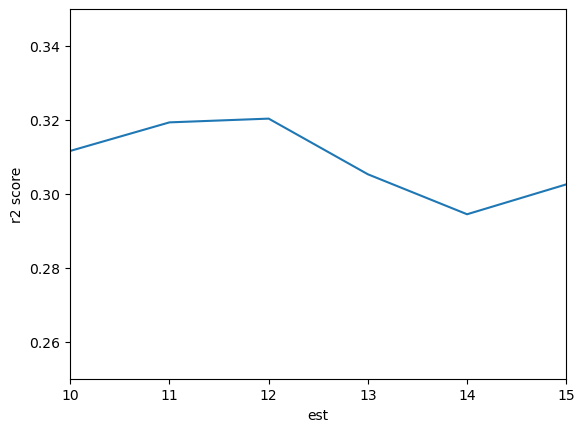

In [120]:
g = sns.lineplot(x='est', y='r2 score', data=pd.melt(est_df, ['est'], value_name='r2 score'))
g.set_ylim(0.25, 0.35)
g.set_xlim(10, 15)

In [149]:
print(r2_score(y_test,y_pred))

0.29264187651032336


(0.0, 1.25)

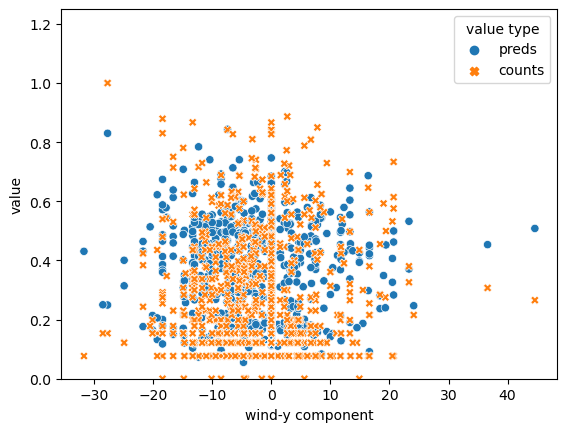

In [134]:
y_df=pd.DataFrame()
y_df['preds']=y_pred
y_df['counts']=y_test
y_df['wind-y component']=weather_complete[['windy006']]
# plot predictions
xy=sns.scatterplot(x='wind-y component', y='value', hue='value type', style="value type", data=pd.melt(y_df, ['wind-y component'], var_name='value type', value_name='value'))
xy.set_ylim(0, 1.25)

## Predictions

In [30]:
from meteostat import Point, Daily, Hourly, Stations

In [31]:
def get_weather(latitude, longitude, month, day, year):
    # find nearest station
    stations = Stations()
    stations = stations.nearby(latitude, longitude)
    station = stations.fetch(2)
    station=station.index
    defective_stations=['72506', '74492', '74494', 'KNZW0']
    # pick a non-defective station
    if station[0] in defective_stations:
        station = station[1]
    else:
        station = station[0]
    # hourly data for station
    weather_for_day=pd.DataFrame(index=[0], columns=['temp', 'prcp', 'wind_x', 'wind_y'])
    start = datetime(year, month, day, 0, 00)
    end = datetime(year, month, day, 12, 00)
    stn = Hourly(station, start, end)
    stn = stn.fetch()
    # fill missing rows of hourly weather with rows of NaN values
    times=[
        datetime(start.year, start.month, start.day, 0, 00),
        datetime(start.year, start.month, start.day, 1, 00),
        datetime(start.year, start.month, start.day, 2, 00),
        datetime(start.year, start.month, start.day, 3, 00), 
        datetime(start.year, start.month, start.day, 4, 00),
        datetime(start.year, start.month, start.day, 5, 00),
        datetime(start.year, start.month, start.day, 6, 00),
        datetime(start.year, start.month, start.day, 7, 00),
        datetime(start.year, start.month, start.day, 8, 00),
        datetime(start.year, start.month, start.day, 9, 00),
        datetime(start.year, start.month, start.day, 10, 00),
        datetime(start.year, start.month, start.day, 11, 00),
        datetime(start.year, start.month, start.day, 12, 00),
    ]
    nan_row=pd.Series({"temp":np.nan, "dwpt":np.nan, "rhum":np.nan, "prcp":np.nan, "snow": np.nan, "wdir":np.nan, "wspd":np.nan, "wpgt":np.nan, "pres":np.nan, "tsun":np.nan, "coco":np.nan})
    for time in times:
        if time not in stn.index:
            stn=pd.concat([stn, nan_row.to_frame(time).T])
    stn=stn.sort_index()
    # filter to every 3 hrs
    counter=-1 
    for index, row in stn.iterrows():
        counter+=1  
        if counter%3!=0:
            stn=stn.drop(index)
    # replace NaNs
    stn['prcp']=stn['prcp'].fillna(0)
    stn['temp']=stn['temp'].interpolate(method='linear', limit_direction='both')
    stn['wdir']=stn['wdir'].interpolate(method='linear', limit_direction='both')
    stn['wspd']=stn['wspd'].interpolate(method='linear', limit_direction='both')
    # create a list for each parameter
    stn_temp=stn['temp'].tolist()
    stn_prcp=stn['prcp'].tolist()
    stn_wdir=stn['wdir'].tolist()
    stn_wspd=stn['wspd'].tolist()
    # convert wind speed and wind direction into x and y components
    stn_wind_x=[]
    stn_wind_y=[]
    for i in range(5):
        cosine=np.around(np.cos(np.deg2rad(stn_wdir[i])), decimals=1)
        sine=np.around(np.sin(np.deg2rad(stn_wdir[i])), decimals=1)
        hourly_wind_x=np.around(float(stn_wspd[i])*cosine, decimals=1)
        hourly_wind_y=np.around(float(stn_wspd[i])*sine, decimals=1)
        stn_wind_x.append(hourly_wind_x)
        stn_wind_y.append(hourly_wind_y)
    stn_wind_x=pd.Series(stn_wind_x, dtype=object).fillna(0).tolist()
    stn_wind_y=pd.Series(stn_wind_y, dtype=object).fillna(0).tolist()
    # create a dataframe
    temp_df=pd.DataFrame([stn_temp], columns=['temp000','temp003','temp006','temp009','temp012'])
    prcp_df=pd.DataFrame([stn_prcp], columns=['prcp000','prcp003','prcp006','prcp009','prcp012'])
    wdir_df=pd.DataFrame([stn_wdir], columns=['wdir000','wdir003','wdir006','wdir009','wdir012'])
    wspd_df=pd.DataFrame([stn_wspd], columns=['wspd000','wspd003','wspd006','wspd009','wspd012'])
    windx_df=pd.DataFrame([stn_wind_x], columns=['windx000','windx003','windx006','windx009','windx012'])
    windy_df=pd.DataFrame([stn_wind_y], columns=['windy000','windy003','windy006','windy009','windy012'])
    weather_for_day=pd.concat([windx_df,windy_df], axis=1)
    # add day using day_in_the_year function
    def days_in_a_year(month, day):
        return np.piecewise(1, [month==1, month==2, month==3, month==4, month==5, month==6, month==7, month==8, month==9, month==10, month==11, month==12], [day,31+day,60+day,91+day,121+day,152+day,182+day,213+day,244+day,274+day,305+day,335+day])
    weather_for_day['days_cos']=np.cos(np.deg2rad(days_in_a_year(month, day)*(60/61)))
    weather_for_day['days_sin']=np.sin(np.deg2rad(days_in_a_year(month, day)*(60/61)))
    return weather_for_day

In [32]:
def df_to_numpy_scaled(weather_for_day):
    # keep specific columns
    weather_0609_cos_sin_1=weather_for_day[weather_for_day.columns[2:4]]
    weather_0609_cos_sin_2=weather_for_day[weather_for_day.columns[7:9]]
    weather_0609_cos_sin_3=weather_for_day[weather_for_day.columns[-2:]]
    weather_0609_cos_sin=pd.concat([weather_0609_cos_sin_1,weather_0609_cos_sin_2, weather_0609_cos_sin_3], axis=1)
    # convert dataframe to numpy array
    x_test=weather_0609_cos_sin.to_numpy()
    # scale weather parameters, latitude, and longitude, so that the standard deviation is 1
    # normalize X values using StandardScaler() formula: z=(x-u)/s
    # wind_X
    x_test[0, 0:2]-=windx_avg
    x_test[0, 0:2]=np.divide(x_test[0, 0:2], windx_std)
    # wind_y
    x_test[0, 2:4]-=windy_avg
    x_test[0, 2:4]=np.divide(x_test[0, 2:4], windy_std)
    return x_test

In [140]:
def predict_northern_gannets(latitude, longitude, month, day, year, count, weather):
    # create x_test
    x_test=df_to_numpy_scaled(get_weather(latitude, longitude, month, day, year))
    # predict number of nogas
    noga_count=model_xgb1.predict(x_test)
    # the noga count in scaled so we unscale it
    noga_count=float(str(noga_count).replace("[", "").replace("]", ""))
    # get original count by using the formula: y=z*(max-min)+min
    noga_count=np.multiply(noga_count, counts_max-counts_min)
    noga_count+=counts_min
    noga_count=round(np.exp(noga_count)-1,0)
    noga_prediction='Actual Count: '+str(count)+'\tPred: '+str(noga_count)+'\tWeather: '+str(weather)+'\tDay: '+str(month)+'/'+str(day)+'/'+str(year)
    print('___________________________________________________________________________________________')
    return noga_prediction

In [152]:
print(predict_northern_gannets(42.691015, -70.631701, 1, 29, 2024, 0.0, 'N, 5 mph'))
# count: 1; SE, 5-12 mph
print(predict_northern_gannets(42.691015, -70.631701, 1, 28, 2024, 1.0, 'SE, 5-12 mph'))
print(predict_northern_gannets(42.691015, -70.631701, 1, 10, 2024, 180, 'ENE, 5-10 mph'))
print(predict_northern_gannets(42.691015, -70.631701, 5, 28, 2024, 823, 'SE, 10-15 mph'))
print(predict_northern_gannets(42.691015, -70.631701, 5, 18, 2024, 182, '---, --- mph'))
print(predict_northern_gannets(42.691015, -70.631701, 1, 17, 2024, '~0-10', 'WNW, 10 mph'))
print(predict_northern_gannets(42.691015, -70.631701, 2, 10, 2024, 0.0, 'WSW, 0-5 mph'))
print(predict_northern_gannets(42.691015, -70.631701, 1, 13, 2024, 459, 'ESE, 30-45 mph'))
print(predict_northern_gannets(42.691015, -70.631701, 1, 10, 2024, 180, '---, --- mph'))
print(predict_northern_gannets(42.691015, -70.631701, 11, 1, 2023, 500, 'E, 5-10 mph'))
print(predict_northern_gannets(42.691015, -70.631701, 4, 23, 2023, 78, 'E, 20-25 mph'))

# count: 63; SE, 10-20 mph
print(predict_northern_gannets(42.691015, -70.631701, 12, 17, 2023, 63, 'SE, 10-20 mph'))
print(predict_northern_gannets(42.691015, -70.631701, 11, 30, 2023, 4.0, '---, 2 mph'))
# count: 848; SE, 25-35 mph 
print(predict_northern_gannets(42.691015, -70.631701, 11, 22, 2023, 1450, 'SE, 25-35 mph'))
# count: 265; N, 6 mph
print(predict_northern_gannets(42.691015, -70.631701, 11, 6, 2023, 265, 'N, 6 mph'))
# count: 46; N, 10 mph
print(predict_northern_gannets(42.691015, -70.631701, 10, 1, 2023, 46, 'N, 10 mph'))
# count: 475; NW, 30-35 mph
print(predict_northern_gannets(42.691015, -70.631701, 9, 16, 2023, 475, 'NW, 30-35 mph'))
# count: 1; S, 10-20 mph
print(predict_northern_gannets(42.691015, -70.631701, 7, 16, 2023, 1.0, 'S, 10-20 mph'))
print(predict_northern_gannets(42.691015, -70.631701, 4, 16, 2023, '~1', '---, - mph'))
# count: 2; NNE, 20-30 mph
print(predict_northern_gannets(42.691015, -70.631701, 3, 11, 2023, 2.0, 'NNE, 20-30 mph'))
print('************ ***********************************************************************')
# count: 295; E-ENE, 25-45 mph
print(predict_northern_gannets(42.691015, -70.631701, 12, 16, 2022, 295, 'ENE, 25-45 mph'))
# count: ~1500; E, 20-30 mph
print(predict_northern_gannets(42.691015, -70.631701, 10, 2, 2022, 1500, 'E, 20-30 mph'))
# count: 31; W, 10-15 mph
print(predict_northern_gannets(42.691015, -70.631701, 8, 31, 2022, 31, 'W, 10-15 mph'))
# count: 11; W, 5-10 mph
print(predict_northern_gannets(42.691015, -70.631701, 7, 8, 2022, 11, 'W, 5-10 mph'))
# count: 115, -, - mph
print(predict_northern_gannets(42.691015, -70.631701, 11, 13, 2021, 115, '-, --- mph'))

___________________________________________________________________________________________
Actual Count: 0.0	Pred: 7.0	Weather: N, 5 mph	Day: 1/29/2024
___________________________________________________________________________________________
Actual Count: 1.0	Pred: 4.0	Weather: SE, 5-12 mph	Day: 1/28/2024
___________________________________________________________________________________________
Actual Count: 180	Pred: 32.0	Weather: ENE, 5-10 mph	Day: 1/10/2024
___________________________________________________________________________________________
Actual Count: 823	Pred: 9.0	Weather: SE, 10-15 mph	Day: 5/28/2024
___________________________________________________________________________________________
Actual Count: 182	Pred: 27.0	Weather: ---, --- mph	Day: 5/18/2024
___________________________________________________________________________________________
Actual Count: ~0-10	Pred: 6.0	Weather: WNW, 10 mph	Day: 1/17/2024
_________________________________________________________